<a href="https://colab.research.google.com/github/vicentcamison/idal_ia3/blob/main/3%20Aprendizaje%20profundo%20(II)/Sesion%205/B0_RNNvsGRU_PT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![IDAL](https://i.imgur.com/tIKXIG1.jpg)  

#**Máster en Inteligencia Artificial Avanzada y Aplicada:  IA^3**
---

# <strong><center>RNN simple VS GRU</strong>
En este ejemplo vamos a estudiar la mejora que se produce al emplear distitas arquitecturas de redes recurrentes. 
Vamos a entrenar dos modelos diferentes (ligeramente) empleando las imágenes del famoso dataset MNIST y en igualdad de condiciones para poder evaluar sus resultados, además de practicar la configuración de redes recurrentes con Pytorch

In [1]:
# Necesidades del guión...
!pip3 install torch torchvision

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

Definimos los hiperparámetros comunes

In [3]:
# Hyper-parametros 
# input_size = 784 # 28x28
num_classes = 10
num_epochs = 2
batch_size = 100
learning_rate = 0.001

input_size = 28
sequence_length = 28
hidden_size = 128
num_layers = 2

In [4]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


El código anterior carga y prepara el conjunto de datos para introducirlo en el gráfico de cálculo que construiremos más adelante. Tómese unos minutos para jugar con el código y entender lo que está sucediendo. 
Fíjate en que necesitamos proporcionar un tamaño de lote. Esto se debe a que `trainloader` y `testloader` son iteradores que harán más fácil cuando estemos iterando sobre el conjunto de datos y entrenando nuestro modelo RNN con minilotes.

#### Exploración del conjunto de datos
Vamos a explorar el conjunto de datos y comprobar que se ha cargado correctamente.

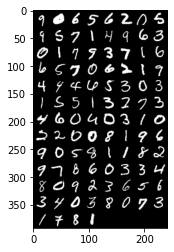

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# cogemos imágenes aleatorias
dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

## Modelo RNN simple


Definimos una red recurrente simple, tambien conocida como *vanilla RNN*

In [7]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size

        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)       
        out, _ = self.rnn(x, h0)
        # Decodifica el estado oculto del ultimmo paso
        out = out[:, -1, :]
        out = self.fc(out)

        return out

In [8]:
model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

In [10]:
# Entrenamiento
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # origin shape: [N, 1, 28, 28]
        # resized: [N, 28, 28]
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward y optimiza
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

Epoch [1/2], Step [100/600], Loss: 0.8573
Epoch [1/2], Step [200/600], Loss: 0.5654
Epoch [1/2], Step [300/600], Loss: 0.3504
Epoch [1/2], Step [400/600], Loss: 0.4191
Epoch [1/2], Step [500/600], Loss: 0.2197
Epoch [1/2], Step [600/600], Loss: 0.2103
Epoch [2/2], Step [100/600], Loss: 0.2760
Epoch [2/2], Step [200/600], Loss: 0.2014
Epoch [2/2], Step [300/600], Loss: 0.2789
Epoch [2/2], Step [400/600], Loss: 0.3383
Epoch [2/2], Step [500/600], Loss: 0.3129
Epoch [2/2], Step [600/600], Loss: 0.1774


In [11]:
# Test 
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Precision de la red con las 10000 imagenes de test: {acc} %')

Precision de la red con las 10000 imagenes de test: 93.83 %


##Modelo GRU

Ahora definimos una GRU, un modelo evolucionado a partir de las rnn simple, que compensa algunos de los problemas incorporando mecanismos (*gates*) para controlar que parte de información se retiene y se olvida y solucionar ciertos problemas que tiene las rrns simples

In [12]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(GRU, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        out, _ = self.gru(x, h0)  
        # Decodifica el estado oculto del ultimmo paso
        out = out[:, -1, :]
        out = self.fc(out)
        return out


In [13]:
GRUmodel = GRU(input_size, hidden_size, num_layers, num_classes).to(device)

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(GRUmodel.parameters(), lr=learning_rate) 

In [15]:
# Entrenamiento
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # origin shape: [N, 1, 28, 28]
        # resized: [N, 28, 28]
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = GRUmodel(images)
        loss = criterion(outputs, labels)
        
        # Backward y optimiza
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

Epoch [1/2], Step [100/600], Loss: 0.8902
Epoch [1/2], Step [200/600], Loss: 0.4021
Epoch [1/2], Step [300/600], Loss: 0.2184
Epoch [1/2], Step [400/600], Loss: 0.3188
Epoch [1/2], Step [500/600], Loss: 0.1904
Epoch [1/2], Step [600/600], Loss: 0.0909
Epoch [2/2], Step [100/600], Loss: 0.1879
Epoch [2/2], Step [200/600], Loss: 0.1514
Epoch [2/2], Step [300/600], Loss: 0.0238
Epoch [2/2], Step [400/600], Loss: 0.0595
Epoch [2/2], Step [500/600], Loss: 0.0586
Epoch [2/2], Step [600/600], Loss: 0.1496


In [16]:
# Test 
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        outputs = GRUmodel(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Precision de la red con las 10000 imagenes de test: {acc} %')

Precision de la red con las 10000 imagenes de test: 97.39 %


Observa los resultados obtenidos 
* ¿que modelo lo ha hecho mejor? 
* ¿Porqué crees que es así?
* ¿como se pueden mejorar?


## Referencias
- [A Simple Neural Network from Scratch with PyTorch and Google Colab](https://github.com/omarsar/pytorch_intro_neural_network/blob/master/nn.ipynb)
- [Hands on Machine Learning with Scikit-learn and Tensorflow](http://shop.oreilly.com/product/0636920052289.do)

##Fin del cuaderno